In [1]:
from typing import Sequence

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Préparation générale des données

- (Déposer manuellement une des images récupérées par webscraping ou API dans le même dossier que le notebook ou travailler avec une image déjà présente.)
- Trouver la fonction d'OpenCV (cv2) permettant de charger une image, et l'utiliser pour charger l'image choisie. <br>
- A l'aide de la fonction cvtColor de cv2, convertir l'image vers l'espace COLOR_BGR2RGB.

In [2]:
def load_image(image_name: str) -> np.ndarray:
    """Load image from current folder with OpenCV."""
    return cv2.cvtColor(cv2.imread(image_name), cv2.COLOR_BGR2RGB)

In [3]:
img = load_image("rose.jpg")

- Afficher l'image à l'aide de plt.

In [4]:
def display_image(img: np.ndarray) -> None:
    """Display image with plt."""
    plt.imshow(img)
    plt.show()

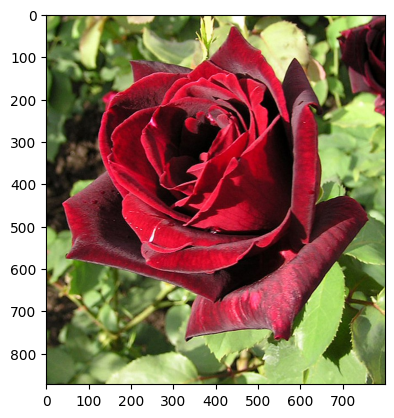

In [5]:
display_image(img)

- Afficher la taille de l'image.

In [6]:
img.shape

(873, 800, 3)

- Séparer ("split") les 3 canaux de couleurs de l'image (bleu, vert, rouge).

In [7]:
blue, green, red = cv2.split(img)

- A l'aide de subplots (plt), afficher les images de chaque canal de couleur. Ajouter à chacune d'elle un titre indiquant la couleur correspondante.

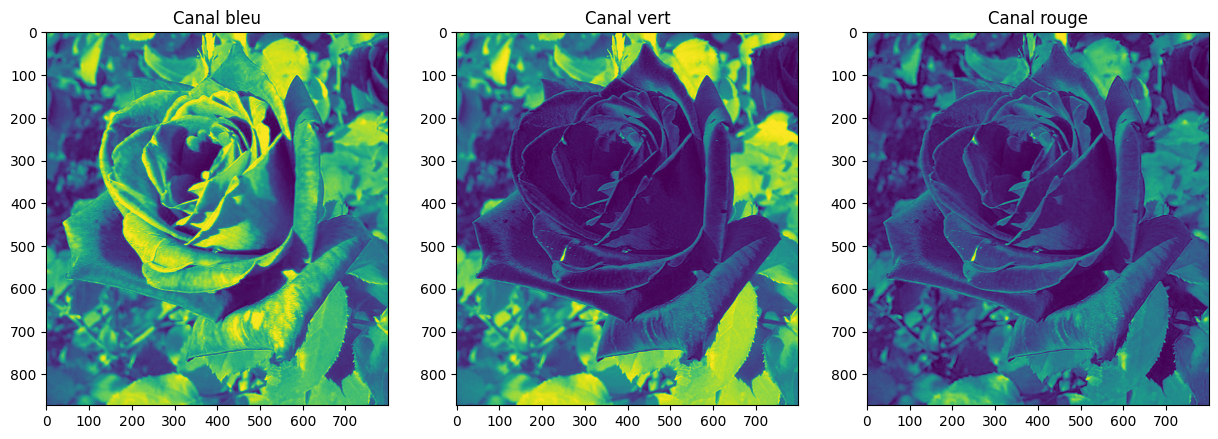

In [8]:
fig = plt.figure(figsize = (15, 7.2)) 
fig.add_subplot(131)
plt.title("Canal bleu")
plt.imshow(blue)

fig.add_subplot(132)
plt.title("Canal vert")
plt.imshow(green)

fig.add_subplot(133)
plt.title("Canal rouge")
plt.imshow(red)

plt.show()

## Préparation spécifique des données

- Afficher les valeurs numériques contenues dans un canal de couleurs. Trouver le minimum et le maximum de ces valeurs.

In [9]:
print(red)
print(red.max())
print(red.min())

[[107 107 112 ...  81  85  89]
 [105 105 108 ...  59  62  64]
 [104 103 105 ...  50  50  52]
 ...
 [ 48  48  48 ...  57  55  55]
 [ 49  46  44 ...  57  56  55]
 [ 49  49  49 ...  50  53  54]]
255
0


- Normaliser les données.

In [10]:
scaled_blue = blue / 255
scaled_green = green / 255
scaled_red = red / 255

## Première ACP

- Préparer une constante comportant le nombre de composantes de l'ACP (200 pour le moment).

In [11]:
n_components: int = 10

- Réaliser 3 ACP distinctes pour chaque canal de couleurs, en fittant sur les données normalisées et en transformant ces mêmes données.

In [12]:
pca_b = PCA(n_components=n_components)
trans_pca_b = pca_b.fit_transform(scaled_blue)

pca_g = PCA(n_components=n_components)
trans_pca_g = pca_g.fit_transform(scaled_green)

pca_r = PCA(n_components=n_components)
trans_pca_r = pca_r.fit_transform(scaled_red)

- Vérifier la taille des matrices ainsi obtenues et les comparer avec les tailles initiales.

In [13]:
print(trans_pca_b.shape)
print(trans_pca_r.shape)
print(trans_pca_g.shape)

(873, 10)
(873, 10)
(873, 10)


In [14]:
def add_subplot(
    x: Sequence[int],
    fitted_pca: PCA,
    subplot_position: int,
    channel_name: str,
) -> None:
    
    explained_variances: Sequence[float] = 100 * fitted_pca.explained_variance_ratio_
    fig.add_subplot(subplot_position)
    plt.title(f"Canal {channel_name}")
    plt.ylabel("Pourcentage d'inertie")
    plt.xlabel("Rang de l'axe d'inertie")
    plt.bar(x, explained_variances)
    plt.plot(x, explained_variances.cumsum(), c="red", marker='o')

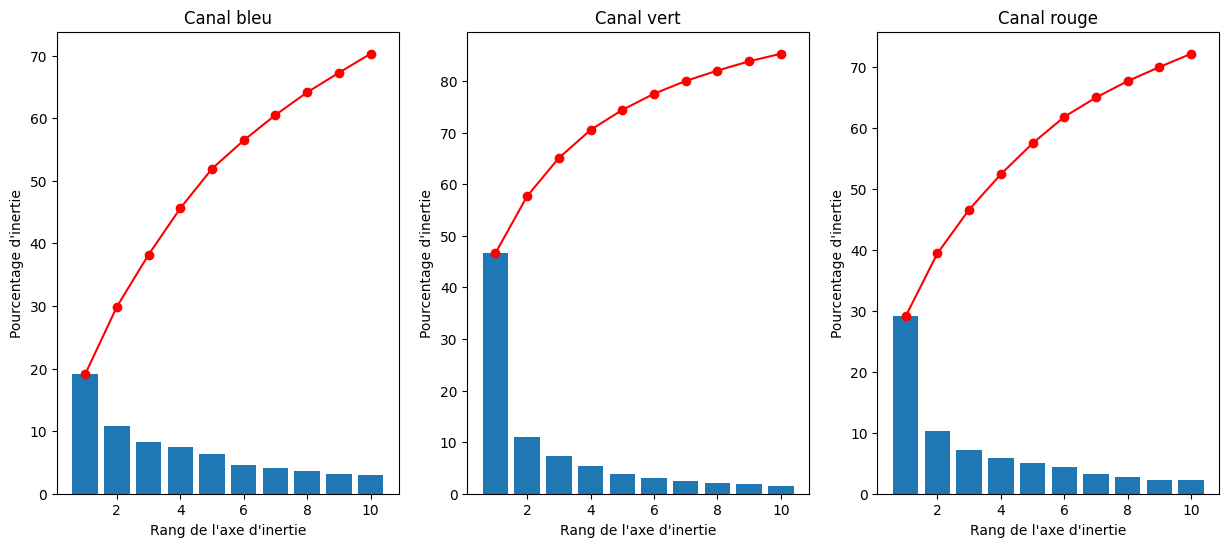

In [15]:
x = list(range(1, n_components + 1))
fig = plt.figure(figsize = (15, 6)) 

add_subplot(
    x=x,
    fitted_pca=pca_b,
    subplot_position=131,
    channel_name="bleu",
)

add_subplot(
    x=x,
    fitted_pca=pca_g,
    subplot_position=132,
    channel_name="vert",
)

add_subplot(
    x=x,
    fitted_pca=pca_r,
    subplot_position=133,
    channel_name="rouge",
)

plt.show()

- Afficher le taux de variance totale expliquée par les n_components premières composantes de l'ACP pour chaque canal de couleur.

In [16]:
print(f"Canal bleu : {sum(pca_b.explained_variance_ratio_)}")
print(f"Canal vert : {sum(pca_g.explained_variance_ratio_)}")
print(f"Canal rouge  : {sum(pca_r.explained_variance_ratio_)}")

Canal bleu : 0.7028874509714603
Canal vert : 0.8528441352815186
Canal rouge  : 0.7214637875330118


### Reconstruction de l'image réduite

- Reconstruire les tableaux numpy des différents canaux à partir des transformées inverses des ACP. Afficher les tailles des objets obtenus. 

In [17]:
b_arr = pca_b.inverse_transform(trans_pca_b)
g_arr = pca_g.inverse_transform(trans_pca_g)
r_arr = pca_r.inverse_transform(trans_pca_r)
print(b_arr.shape, g_arr.shape, r_arr.shape)

(873, 800) (873, 800) (873, 800)


- Reconstruire le tableau numpy de l'image globale à l'aide de la fonction merge de cv2.

In [18]:
img_reduced= cv2.merge((b_arr, g_arr, r_arr))
print(img_reduced.shape)

(873, 800, 3)


- Afficher côte à côte l'image initiale et l'image réduite.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


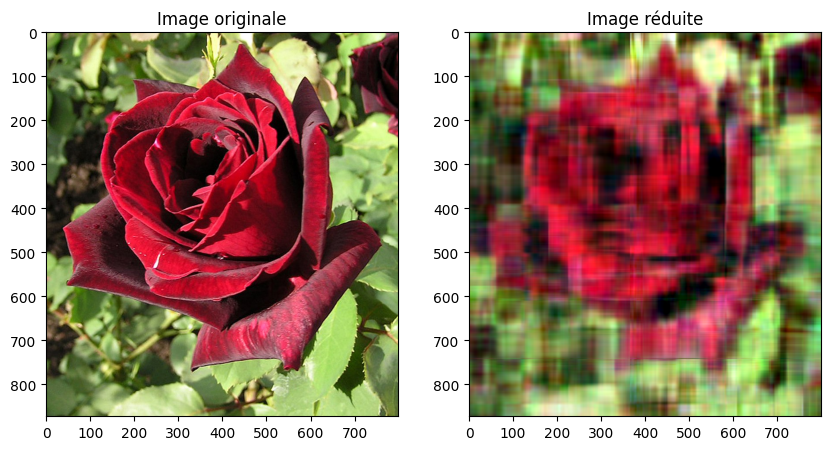

In [19]:
fig = plt.figure(figsize = (10, 7.2))

fig.add_subplot(121)
plt.title("Image originale")
plt.imshow(img)

fig.add_subplot(122)
plt.title("Image réduite")
plt.imshow(img_reduced)

plt.show()

### Réglage du nombre de composantes

- A l'aide de l'éboulis des valeurs propres, proposer une valeur plus restrictive du nombre de composantes permettant malgré tout de "bien" expliquer la "plupart" de la variance. Relancer le code avec cette nouvelle valeur. Essayer éventuellement une valeur trop faible. Conclure quant à l'utilité et aux limites de l'ACP dans le contexte d'étude.

Discussion finale sur la pertinence de la méthode. SVD. Compression JPG. Espace latent (GAN, VAE).